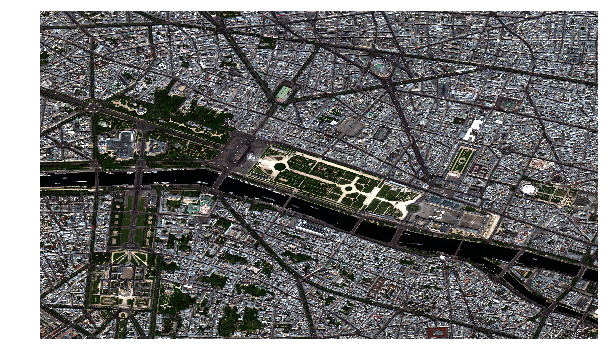

In [1]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
%matplotlib inline

catalog_id = env.inputs.get('catalog_id', '1040050008DC2800')
bbox = env.inputs.get('bbox', '2.3060989379882817, 48.85161367977706, 2.347984313964844, 48.876231845692516')

image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
image.plot(w=10, h=10)

## Measuring Water Change over Theewaterskloof dam

This notebook shows how it is possible to identify water changes in Theewaterskloof dam using Maxar satellite imagery and the NDWI index. 

Fetching Image... 680 tiles


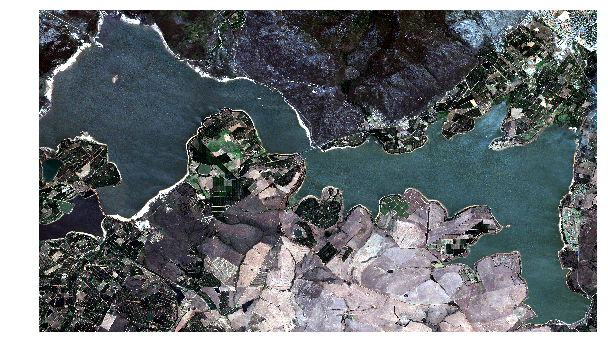

Fetching Image... 608 tiles


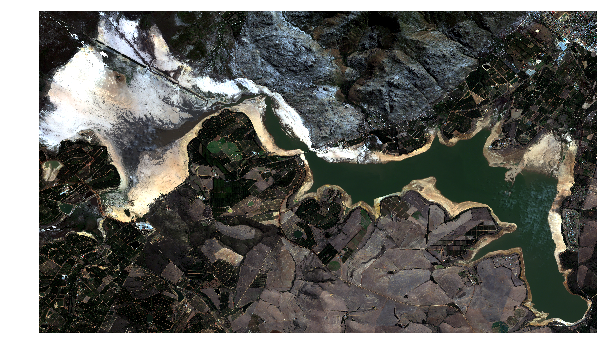

In [1]:
from gbdxtools import CatalogImage
from gbdxtools.task import env
from skimage.transform import resize as imresize
import numpy as np
from skimage.filters import threshold_otsu, gaussian
import matplotlib.pyplot as plt
%matplotlib inline

bbox = env.inputs.get('bbox','19.128843847656254, -34.081070991576994, 19.294395446777347, -33.985641136540136')
catalog_id_before = env.inputs.get('catalog_id_before','103001003D74D800') #19/01/2015
catalog_id_after = env.inputs.get('catalog_id_after','1030010067126000') #22/04/2017

before = CatalogImage(catalog_id_before, bbox=map(float,bbox.split(",")))
after = CatalogImage(catalog_id_after, bbox=map(float,bbox.split(",")))

before.plot()
after.plot()


In [2]:
#Defining functions

def ndwi(img):
    if img.shape[0]==1:
        print("Error: Not enough bands in the image")
    elif img.shape[0]==8:
        ndwi = np.clip((img[2,:,:] - img[7,:,:]) / (img[2,:,:] + img[7,:,:]), -1, 1) #(Green-NIR)/(Green+NIR)
    else:
        ndwi = np.clip((img[1,:,:] - img[3,:,:]) / (img[1,:,:] + img[3,:,:]), -1, 1) #(G-NIR)/(G+NIR)
    return ndwi

def threshold(img):
    img[np.isnan(img)] = 0
    simage = gaussian(img, preserve_range=True)
    sthresh = threshold_otsu(simage)
    return simage > sthresh

## Calculate NDWI Index

In [3]:
b_water = ndwi(before)
a_water = ndwi(after)


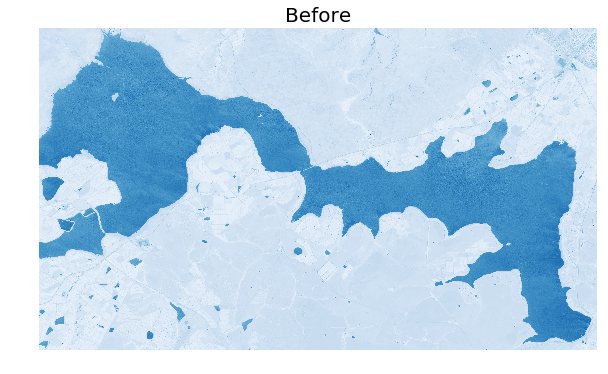

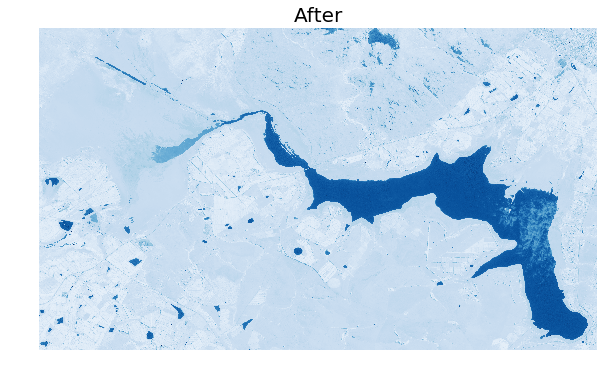

In [5]:
def plot(img, w=10, h=7, cmap='Blues',title="string"):
    f, ax = plt.subplots(1, figsize=(w,h))
    ax.axis('off')
    plt.imshow(img, cmap=cmap)
    #plt.colobar
    plt.title(title, fontsize=20)
    plt.show()

plot(b_water,title="Before")
plot(a_water,title="After")

## Create Water Mask from NDWI

In [5]:
thresh = 0.5
mask_before = b_water
mask_before[mask_before >= thresh] = 1.0
mask_before[mask_before < thresh] = 0.0


thresh = 0
mask_after = a_water
mask_after[mask_after >= thresh] = 1.0
mask_after[mask_after < thresh] = 0.0


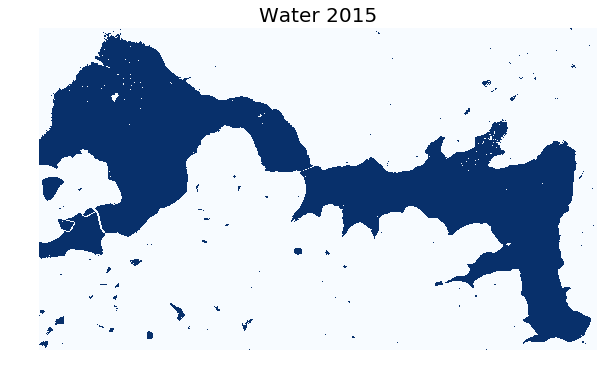

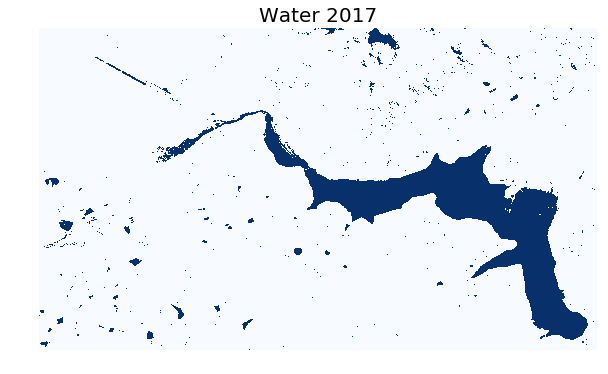

In [6]:
def plot(img, w=10, h=7, cmap='Blues',title="string"):
    f, ax = plt.subplots(1, figsize=(w,h))
    ax.axis('off')
    plt.imshow(img, cmap=cmap)
    plt.title(title, fontsize=20)
    plt.show()
    
plot(mask_before,title='Water 2015')
plot(mask_after,title='Water 2017')

## Measuring water surface


In [7]:
# meters per pixel
mpp = before.ipe_metadata['image']['groundSampleDistanceMeters']

# n-pixels above a threshold
px = np.count_nonzero(mask_before >= .75)

# total area in sq km
sqkm = (mpp * px) / 1000
print 'Water surface in 2015: {} sq. km.'.format(sqkm) 

# meters per pixel
mpp = after.ipe_metadata['image']['groundSampleDistanceMeters']

# n-pixels above a threshold
px = np.count_nonzero(mask_after >= .75)

# total area in sq km
sqkm = (mpp * px) / 1000
print 'Water surface in 2017: {} sq. km.'.format(sqkm) 


Water surface in 2015: 25824.735006 sq. km.
Water surface in 2017: 8660.071879 sq. km.


## Create features and display

In [8]:
from shapely.geometry import box, shape, Polygon
from shapely.ops import cascaded_union
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import label, regionprops
from skimage import feature, morphology
from rasterio import features
from collections import defaultdict, OrderedDict
import json

def clean(img):
    label_img = label(img, connectivity=2)
    props = sorted(regionprops(label_img), key=lambda x: x.area)
    clean = morphology.binary_closing(img)
    
    clean = morphology.remove_small_holes(clean)
    return morphology.remove_small_objects(clean,
                int(np.floor(props[-1].area)/20), connectivity=2)

def extract_features(cimg, index):
    bool_img = clean(threshold(np.clip(water[index], -1, 1))).astype(np.uint8)
    mask = bool_img != 0
    shapes = features.shapes(bool_img, mask=mask, transform=cimg.affine)
    return [shape(s) for s,v in shapes]

catalog_images = [before, after]
water = [mask_before, mask_after]

geojson_images = []
geojson = defaultdict(list)
for index, img in enumerate(catalog_images):
    year = img.ipe_metadata['image']['acquisitionDate'][:4]
    yr_features = extract_features(img, index)
    geojson_images.append(cascaded_union(yr_features))
    geojson[year] += yr_features

geojson = OrderedDict(sorted(geojson.items(), key=lambda t: t[0]))

for year, f in geojson.iteritems():
    union = cascaded_union(f)
    geojson[year] = {"geometry": union.__geo_interface__}
    
output_file = 'water.geojson'
with open(output_file, 'w') as f:
    json.dump(geojson, f)

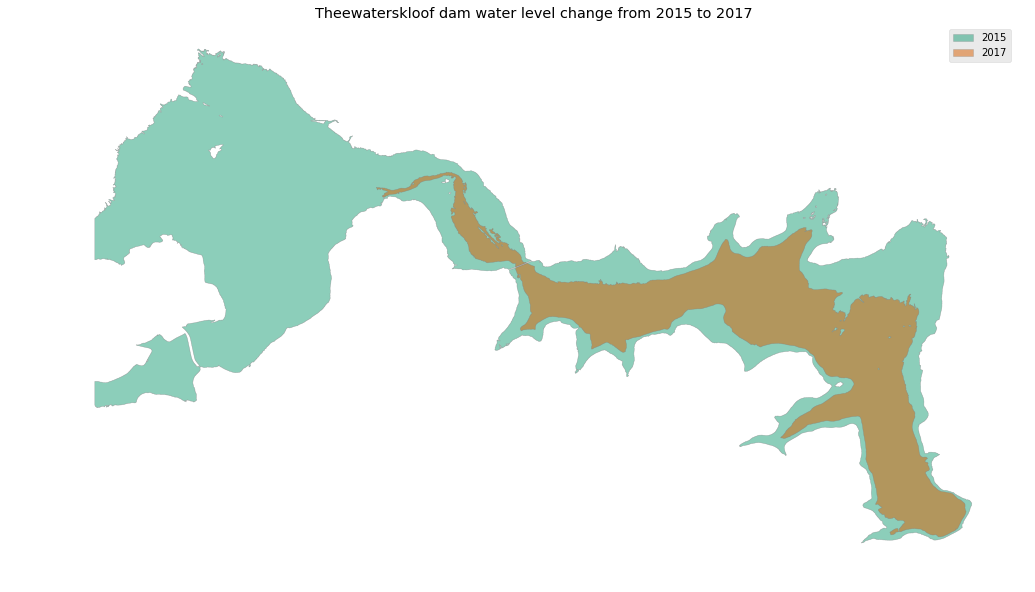

In [9]:
!pip install -q descartes
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
import matplotlib


plt.style.use('ggplot')
fig = plt.figure(figsize=(20,10))

cmap = matplotlib.cm.get_cmap('Dark2')

ax = fig.gca()
ax.axis('off')
patches = []
for i, year in enumerate(geojson.keys()):
    color = cmap(i)
    patches.append(ax.add_patch(PolygonPatch(geojson[year]['geometry'], fc=color, ec='Gray', alpha=.5, zorder=2, label=year )))
ax.legend()
ax.axis('scaled')
plt.title('Theewaterskloof dam water level change from 2015 to 2017')
plt.show()

In [21]:
from gbdxtools import Interface
gbdx = Interface()

gbdx.vectors.map([geojson['2017']]+[geojson['2015']])

<IPython.core.display.Javascript object>